# CNN based binary-classifier on computer generated images

In this notebook, we will build a **binary classifier** to classify colored images of **horses** and **humans** using **convolutional neural network**. These images are created by computer. This is an example of computer vision on colored images.

The following python code will use the OS library to use Operating System libraries, giving us access to the file system, and the zipfile library allowing us to unzip the data. 

*Un-comment the commented code in below cell only iff this notebook is run for first time. If data is already available in the directory, use directly.*

In [3]:
import zipfile

# Uncomment below part iff you're running this notebook for the first time.
local_zip = '/content/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/horse-or-human')
local_zip = '/content/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/validation-horse-or-human')
zip_ref.close()

The training set `./horse-or-human`, which in turn each contain `horses` and `humans` subdirectories, is the data that is used to tell the neural network model that 'this is what a horse looks like', 'this is what a human looks like' etc. 

One thing to pay attention to in this sample: We do not explicitly label the images as horses or humans.Tensorflow has something called an ImageGenerator -- it reads images from subdirectories, and automatically label them from the name of that subdirectory. For example, we will have a 'training' directory containing a 'horses' directory and a 'humans' directory. ImageGenerator will label the images from respective directories appropriately for us, reducing a coding step. 

However, we will have to define those directories to make it easy for the ImageGenerator to read and label the images.

In [4]:
import os

# Directory with training horse pictures
train_horse_dir = os.path.join('/content/horse-or-human/horses')

# Directory with training human pictures
train_human_dir = os.path.join('/content/horse-or-human/humans')

# Directory with validation horse pictures
validation_horse_dir = os.path.join('/content/validation-horse-or-human/horses')

# Directory with validation human pictures
validation_human_dir = os.path.join('/content/validation-horse-or-human/humans')

Now, let's see what the filenames look like in the `horses` and `humans` training directories:

In [5]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

validation_horse_hames = os.listdir(validation_horse_dir)
print(validation_horse_hames[:10])

validation_human_names = os.listdir(validation_human_dir)
print(validation_human_names[:10])

['horse42-4.png', 'horse41-2.png', 'horse47-2.png', 'horse27-5.png', 'horse33-1.png', 'horse19-6.png', 'horse42-8.png', 'horse44-0.png', 'horse43-4.png', 'horse19-8.png']
['human04-18.png', 'human15-16.png', 'human01-07.png', 'human10-00.png', 'human01-03.png', 'human07-06.png', 'human03-16.png', 'human07-13.png', 'human11-30.png', 'human17-04.png']
['horse4-556.png', 'horse4-072.png', 'horse5-342.png', 'horse1-298.png', 'horse3-541.png', 'horse4-468.png', 'horse4-530.png', 'horse3-011.png', 'horse5-275.png', 'horse2-544.png']
['valhuman04-10.png', 'valhuman03-21.png', 'valhuman01-02.png', 'valhuman01-07.png', 'valhuman02-00.png', 'valhuman01-20.png', 'valhuman03-10.png', 'valhuman01-03.png', 'valhuman02-22.png', 'valhuman04-01.png']


Let's find out the total number of horse and human images in the directories:

In [6]:
print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))
print('total validation horse images:', len(os.listdir(validation_horse_dir)))
print('total validation human images:', len(os.listdir(validation_human_dir)))

total training horse images: 500
total training human images: 527
total validation horse images: 128
total validation human images: 128


Now let's take a look at a few pictures to get a better sense of what they look like. First, configure the matplot parameters:

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, we will display a batch of 8 horse and 8 human pictures:

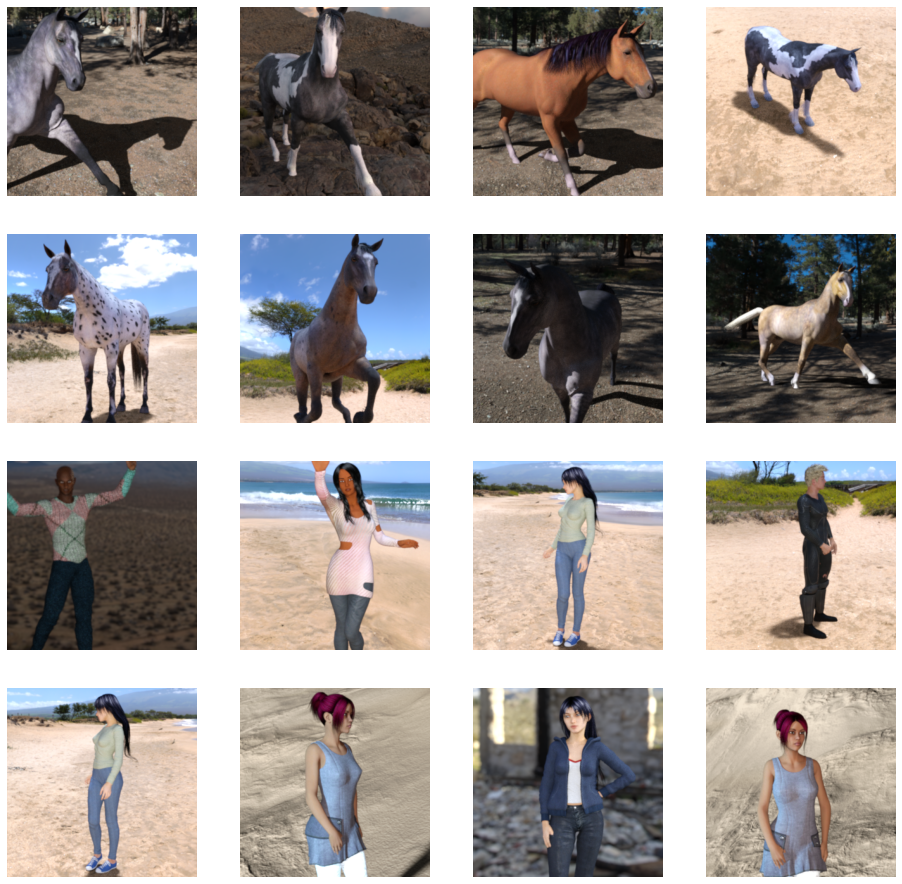

In [8]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


### A classification model from scratch

In [9]:
import tensorflow as tf

We will start with defining the model:

We first add convolutional layers combined with maxpool layers, and flatten the final result to feed into the densely connected layers.

Finally we add the densely connected layers. 

As we are facing a two-class classification problem, i.e. a *binary classification problem*, we will end our network with a *sigmoid* activation, so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

In [10]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for one class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

The model.summary() method call will print a summary of the NN. 

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

The "output shape" column shows how the size of our feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the dimensions.

Next, we'll configure the specifications for model training. We will train our model with the `binary_crossentropy` loss, because it's a binary classification problem and our final activation will be sigmoid. We will use the `rmsprop` optimizer with a learning rate of `0.001`. During training, we will want to monitor classification accuracy.

Using the *RMSprop optimization algorithm* is preferable to *stochastic gradient descent* (SGD), because RMSprop automates learning-rate tuning for us. Other optimizers, such as Adam and Adagrad, also automatically adapt the learning rate during training, and would work equally well.

In [12]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of images of size 300x300 and their labels (binary).

We know that the data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. Therefore, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

We can do this very easily via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows us to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit_generator`, `evaluate_generator`, and `predict_generator`.

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/content/horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 32 using validation_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/content/validation-horse-or-human/',  # This is the source directory for validation images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


### Training
We will train our model for 15 epochs.

The Loss and Accuracy are a great indication of progress of training. It's making a guess as to the classification of the training data, and then measuring it against the known label, calculating the result. Accuracy is the portion of correct guesses. 

In [14]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
8/8 [==============================] - 8s 954ms/step - loss: 1.1766 - acc: 0.5539 - val_loss: 0.6877 - val_acc: 0.5000
Epoch 2/15
8/8 [==============================] - 8s 958ms/step - loss: 0.6588 - acc: 0.5695 - val_loss: 0.6691 - val_acc: 0.5586
Epoch 3/15
8/8 [==============================] - 8s 999ms/step - loss: 1.1035 - acc: 0.7285 - val_loss: 0.4803 - val_acc: 0.7891
Epoch 4/15
8/8 [==============================] - 8s 968ms/step - loss: 0.4813 - acc: 0.7976 - val_loss: 0.4711 - val_acc: 0.8633
Epoch 5/15
8/8 [==============================] - 8s 960ms/step - loss: 0.2354 - acc: 0.9099 - val_loss: 0.9415 - val_acc: 0.8672
Epoch 6/15
8/8 [==============================] - 8s 957ms/step - loss: 0.3383 - acc: 0.8765 - val_loss: 0.6316 - val_acc: 0.8438
Epoch 7/15
8/8 [==============================] - 8s 960ms/step - loss: 0.2404 - acc: 0.9121 - val_loss: 0.7969 - val_acc: 0.8477
Epoch 8/15
8/8

### Running the Model

We will now run a prediction using the model. 

- Below code allows us to choose 1 or more files from our file system. 
- It will then upload them, and run them through the model, giving an indication of whether the object is a horse or a human.

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = './' + fn
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")
 

Using TensorFlow backend.


### Visualizing Intermediate Representations

To get a feel for what kind of features our convnet has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convnet.

Let's pick a random image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


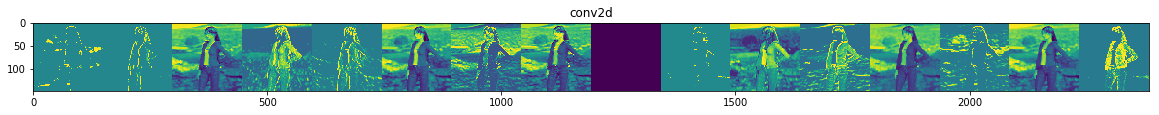

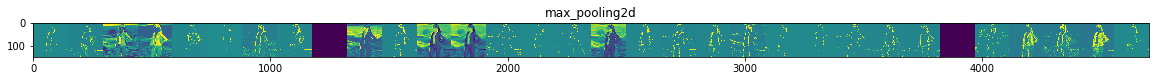

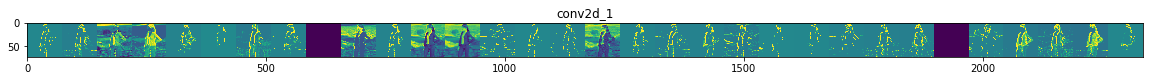

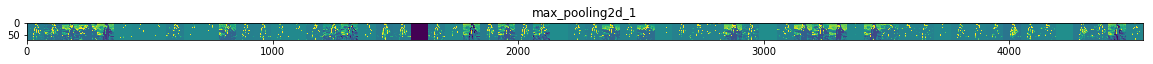

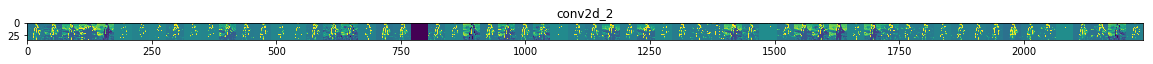

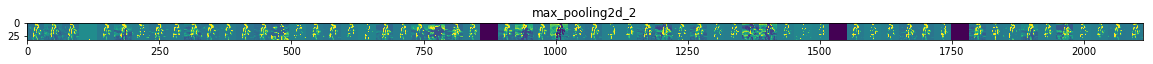

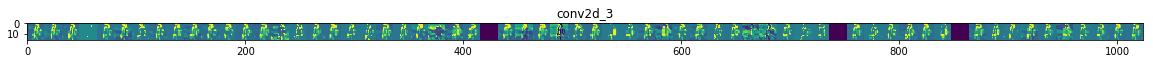

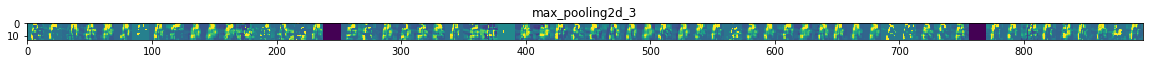

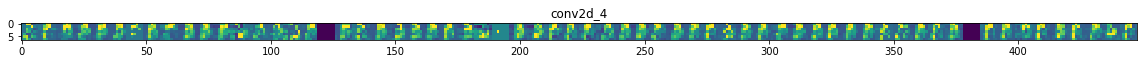

In [ ]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(300, 300))
x = img_to_array(img)  # Numpy array with shape (300, 300, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 300, 300, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

As we can see that we go from the raw pixels of the images to increasingly abstract and compact representations. The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called "sparsity." Representation sparsity is a key feature of deep learning.


These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. We can think of a convnet (or a deep network in general) as an information distillation pipeline.